# 0. Thêm thư viện

Các thư viện cần thiết, trong đó có `yfinance` để lấy data

In [80]:
import pandas as pd
import yfinance as yf
import numpy as np

import warnings
warnings.filterwarnings("ignore")


# 1. Lấy Data

hàm lấy data, là cổ phiếu của 50 công ty trên sàn `EURO_STOXX_50` \
Kết quả trả về là 1 dataframe có dạng m dòng, 50 cột với m là time range 

In [81]:
def EU_Stock_data(start_time,end_time, time_range = 'max'):
    """Lấy dữ liệu giá Close của 50 công ty trên sàn Euro_STOXX 50 vào thời gian cho trước"""

    stock_list = pd.read_html( 'https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]['Ticker'].to_list()

    futures = pd.DataFrame()  

    # xét từng mã
    for symbol in stock_list:
        try:
            df = yf.Ticker(symbol).history(period = time_range, start = start_time, end = end_time)
            df = pd.DataFrame(df['Close'])
            df.columns = [symbol]
            df.index = df.index.date
            futures = pd.concat([futures,df],axis = 1, join = 'outer').sort_index()
        except:
            continue

    futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d')
    futures.set_index('Date', inplace=True)

    return futures

# 2. Tính toán Volatility

Hàm thực hiện tính toán để lấy về giá trị volatility (biến động) của mỗi ngày

In [82]:
def Volatility_scale(data, ignore_na=False, adjust = True, com = 60, min_periods=0):
    """Scale data using ex ante volatility"""

    # Lưu trữ index, tức thời gian 
    std_index = data.index

    # chứa kết quả
    daily_index = pd.DataFrame(index=std_index)

    # xét từng cổ phiếu
    for oo in data.columns:
        returns = data[oo]  # Lấy ra các return
        returns.dropna(inplace=True)  # xử lý null bằng zero

        returns = returns.rolling(2).apply(lambda x: x.iloc[1] / x.iloc[0] - 1)
        returns.iloc[0] =  0

        # Tính cumulative (cum) return , nhưng ko có thành phần - 1
        ret_index = (1 + returns).cumprod()

        # Tính daily volatility (vol)
        day_vol = returns.ewm(ignore_na=ignore_na,
                              adjust=adjust,
                              com=com,
                              min_periods=min_periods).std(bias=False)
        
        vol = day_vol * np.sqrt(252)  # scale lại theo 252 ngày active trading

        # Join cum return và vol
        ret_index = pd.concat([ret_index, vol], axis=1)
        ret_index.columns = [oo, oo + '_Vol']  # Đặt tên cột cum return là tên cổ phiếu, bên cạnh là vol 

        # Join 
        daily_index = pd.concat([daily_index, ret_index], join = 'outer' ,axis=1)

    return daily_index


In [93]:
# Sử dụng hàm để lấy dữ liệu và tính toán
start_time = '2010-01-01'
end_time = '2024-12-31'

# Lấy dữ liệu giá đóng cửa
daily_return = EU_Stock_data(start_time=start_time, end_time=end_time)

# Tính toán volatility và chuẩn hóa
daily_index = Volatility_scale(daily_return)


In [94]:
# Hiển thị kết quả
daily_index.head()

,ADS.DE,ADS.DE_Vol,ADYEN.AS,ADYEN.AS_Vol,AD.AS,AD.AS_Vol,AI.PA,AI.PA_Vol,AIR.PA,AIR.PA_Vol,...,STLAM.MI,STLAM.MI_Vol,TTE.PA,TTE.PA_Vol,DG.PA,DG.PA_Vol,UCG.MI,UCG.MI_Vol,VOW.DE,VOW.DE_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,...,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
2010-01-05,1.031554,0.354196,NaN,NaN,0.991623,0.094037,0.980000,0.224500,0.996783,0.036107,...,1.024785,0.278214,1.001201,0.013481,1.007630,0.085649,0.985355,0.164385,1.008678,0.097410
2010-01-06,1.023244,0.332932,NaN,NaN,0.997243,0.112564,0.973964,0.162160,1.005718,0.100680,...,1.032412,0.201356,1.001856,0.009503,1.021514,0.109507,0.976987,0.116206,1.015593,0.072294
2010-01-07,1.032204,0.270820,NaN,NaN,0.975398,0.191600,0.972781,0.144998,1.015726,0.103850,...,1.028598,0.200564,1.003603,0.011843,1.021889,0.104542,1.000000,0.267811,1.020610,0.058824
2010-01-08,1.028438,0.248197,NaN,NaN,0.985472,0.203764,0.975858,0.144174,1.025733,0.098912,...,1.036225,0.172988,1.004695,0.010294,1.036398,0.109884,1.009414,0.240144,1.031187,0.063088


In [95]:
daily_return.head()

,ADS.DE,ADYEN.AS,AD.AS,AI.PA,AIR.PA,ALV.DE,ABI.BR,ASML.AS,CS.PA,BAS.DE,...,SGO.PA,SAN.PA,SAP.DE,SU.PA,SIE.DE,STLAM.MI,TTE.PA,DG.PA,UCG.MI,VOW.DE
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,31.563414,NaN,5.691657,30.840050,11.342545,43.213928,26.667812,27.166168,7.704947,22.495087,...,25.736799,31.256008,25.707720,28.427855,33.513058,1.441226,18.990194,23.281363,52.170891,40.615837
2010-01-05,32.559376,NaN,5.643975,30.223248,11.306060,43.345707,26.333342,27.216562,7.833363,22.154028,...,25.615026,30.842939,25.477493,28.289944,33.533527,1.476947,19.013000,23.459005,51.406872,40.968300
2010-01-06,32.297077,NaN,5.675964,30.037113,11.407406,43.682491,26.142725,27.507713,7.913622,22.294466,...,25.506413,30.666687,25.930145,28.000319,33.656380,1.487939,19.025444,23.782236,50.970299,41.249172
2010-01-07,32.579876,NaN,5.551629,30.000620,11.520913,43.179771,25.696753,27.003799,7.824190,22.146503,...,25.434013,30.820904,26.616936,27.945154,34.055653,1.482443,19.058615,23.790964,52.170891,41.452934
2010-01-08,32.461014,NaN,5.608967,30.095505,11.634418,42.945488,25.401854,26.096771,7.849414,22.078793,...,25.605152,30.650169,26.804243,27.693459,34.270649,1.493434,19.079357,24.128759,52.662037,41.882507


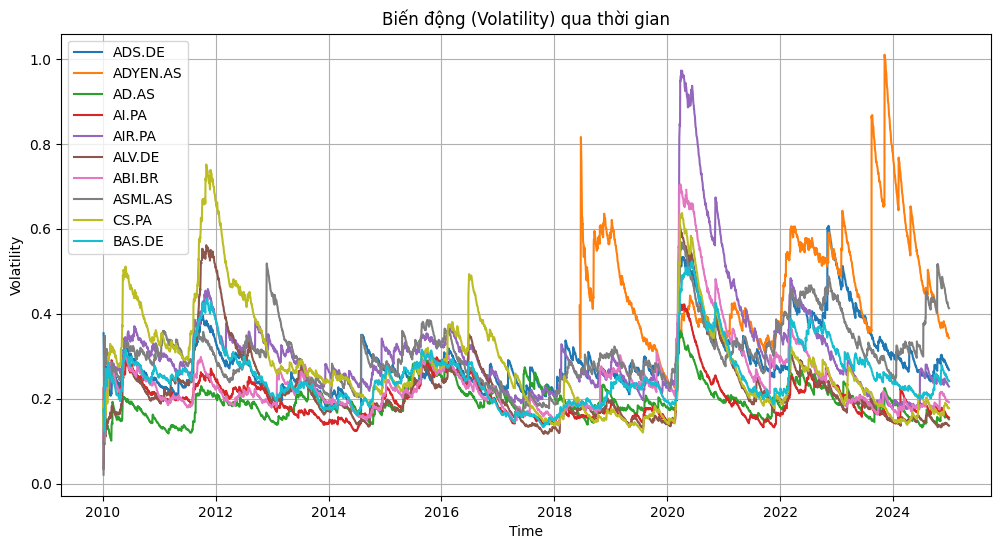

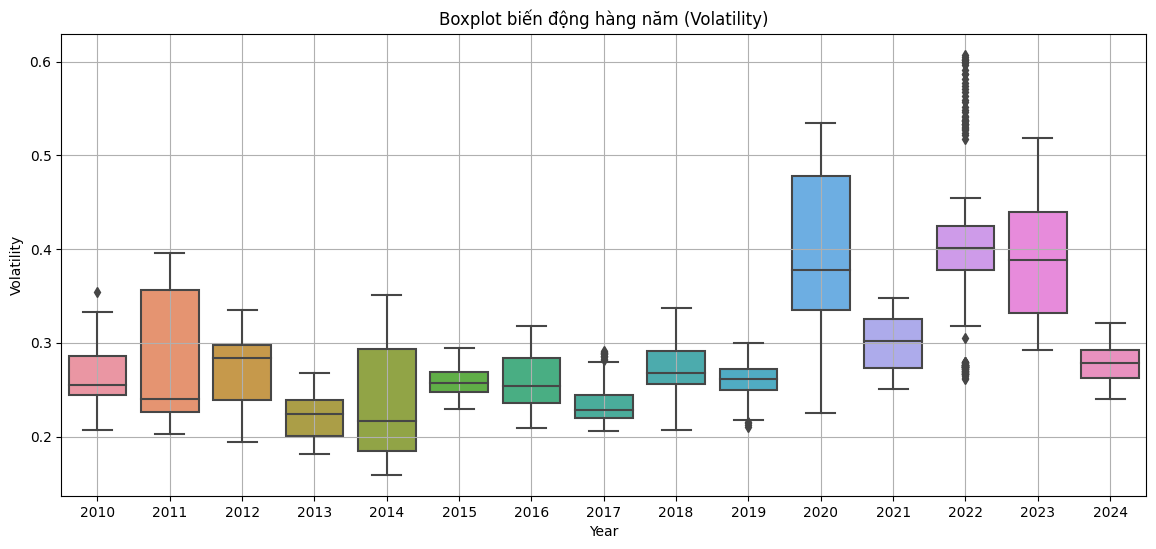

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ biến động qua thời gian
plt.figure(figsize=(12, 6))
for col in daily_index.filter(like='_Vol').columns[:10]:  # Chọn 10 cổ phiếu đầu tiên
    plt.plot(daily_index.index, daily_index[col], label=col.replace('_Vol', ''))
plt.title('Biến động (Volatility) qua thời gian')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot biến động theo từng năm
daily_index['Year'] = daily_index.index.year
plt.figure(figsize=(14, 6))
sns.boxplot(data=daily_index, x='Year', y=daily_index.filter(like='_Vol').iloc[:, 0])
plt.title('Boxplot biến động hàng năm (Volatility)')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

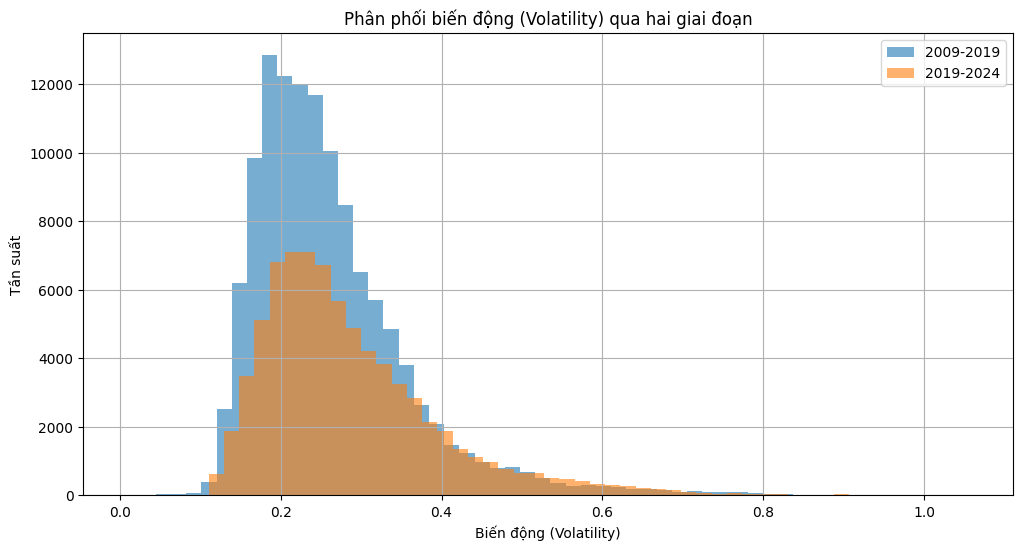

In [101]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(12, 6))
plt.hist(data_2009_2019.filter(like='_Vol').values.flatten(), bins=50, alpha=0.6, label='2009-2019')
plt.hist(data_2019_2024.filter(like='_Vol').values.flatten(), bins=50, alpha=0.6, label='2019-2024')
plt.title('Phân phối biến động (Volatility) qua hai giai đoạn')
plt.xlabel('Biến động (Volatility)')
plt.ylabel('Tần suất')
plt.legend()
plt.grid(True)
plt.show()


In [97]:
# Tính lợi nhuận trung bình và độ biến động trung bình
mean_return = daily_index.filter(like='_Vol').mean(axis=0)
mean_volatility = daily_index.filter(like='_Vol').mean(axis=0)

# Tạo DataFrame chứa các thông tin thống kê
summary_stats = pd.DataFrame({
    'Asset': mean_return.index.str.replace('_Vol', ''),
    'Mean Volatility': mean_volatility.values,
    'Mean Return': daily_index.filter(like='_Vol').mean(axis=0).values
})
print(summary_stats)


        Asset  Mean Volatility  Mean Return
0      ADS.DE         0.288199     0.288199
1    ADYEN.AS         0.469327     0.469327
2       AD.AS         0.193023     0.193023
3       AI.PA         0.199074     0.199074
4      AIR.PA         0.311976     0.311976
5      ALV.DE         0.225955     0.225955
6      ABI.BR         0.241415     0.241415
7     ASML.AS         0.309366     0.309366
8       CS.PA         0.278748     0.278748
9      BAS.DE         0.254759     0.254759
10    BAYN.DE         0.274104     0.274104
11    BBVA.MC         0.329558     0.329558
12     SAN.MC         0.328963     0.328963
13     BMW.DE         0.272604     0.272604
14     BNP.PA         0.326145     0.326145
15      BN.PA         0.189296     0.189296
16     DB1.DE         0.229356     0.229356
17     DHL.DE         0.244489     0.244489
18     DTE.DE         0.201220     0.201220
19    ENEL.MI         0.246285     0.246285
20     ENI.MI         0.247551     0.247551
21      EL.PA         0.219050  